In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# inline plotting instead of popping out
%matplotlib inline


In [2]:
df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv',
    sep=','
)
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:

df = df.drop(['cbwd'], axis=1)      # drop non-scalar feature
df = df.dropna(axis=0, how='any')   # drop samples who has nan feature
df.head()


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0


In [4]:
idx = np.logical_or(
    np.logical_and(df['year'].values == 2014, df['month'].values < 3),
    np.logical_and(df['year'].values == 2013, df['month'].values == 12)
)

X = df.loc[idx].drop('pm2.5', axis=1)      # 所有數值特徵
y = df.loc[idx]['pm2.5'].values           # 目標：pm2.5 濃度

X.head()

,No,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir
34320,34321,2013,12,1,0,-13,-2.0,1026.0,0.89,0,0
34321,34322,2013,12,1,1,-14,-3.0,1025.0,3.13,0,0
34322,34323,2013,12,1,2,-13,-3.0,1025.0,0.89,0,0
34323,34324,2013,12,1,3,-13,-4.0,1025.0,0.89,0,0
34324,34325,2013,12,1,4,-13,-3.0,1025.0,1.78,0,0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# train / test split（7:3）
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y,
    test_size=0.3,
    random_state=0
)

print('# Training samples:', X_train.shape[0])
print('# Testing  samples:', X_test.shape[0])

# 標準化特徵（只對線性/多項式模型使用）
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Training samples: 1491
# Testing  samples: 639


[Polynomial Linear Regression (degree=2)]
# Features after polynomial transform: 363
MSE  train: 3648.76, test: 13857.41
R^2  train: 0.77, test: 0.11


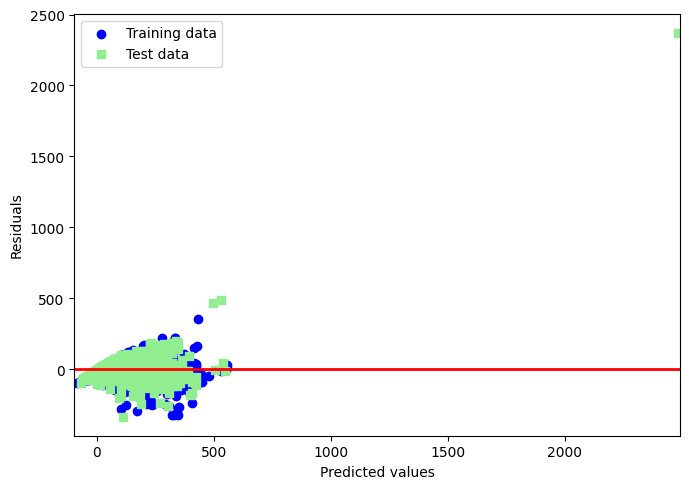

In [14]:
# 建立多項式特徵
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_std)
X_test_poly = poly.transform(X_test_std)

# 線性回歸模型（在多項式特徵空間裡）
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)

# 預測
y_train_pred_lin = lin_reg.predict(X_train_poly)
y_test_pred_lin = lin_reg.predict(X_test_poly)

# 評估
print('[Polynomial Linear Regression (degree=2)]')
print('# Features after polynomial transform:', X_train_poly.shape[1])
print('MSE  train: %.2f, test: %.2f' % (
    mean_squared_error(y_train, y_train_pred_lin),
    mean_squared_error(y_test, y_test_pred_lin)
))
print('R^2  train: %.2f, test: %.2f' % (
    r2_score(y_train, y_train_pred_lin),
    r2_score(y_test, y_test_pred_lin)
))

# 殘差圖
plt.figure(figsize=(7, 5))

plt.scatter(
    y_train_pred_lin,
    y_train_pred_lin - y_train,
    c='blue',
    marker='o',
    label='Training data'
)
plt.scatter(
    y_test_pred_lin,
    y_test_pred_lin - y_test,
    c='lightgreen',
    marker='s',
    label='Test data'
)

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')

xmin = min(y_train_pred_lin.min(), y_test_pred_lin.min()) - 10
xmax = max(y_train_pred_lin.max(), y_test_pred_lin.max()) + 10
plt.hlines(y=0, xmin=xmin, xmax=xmax, lw=2, color='red')
plt.xlim([xmin, xmax])

plt.tight_layout()
plt.show()


[Random Forest Regression]
MSE  train: 201.67, test: 1485.75
R^2  train: 0.99, test: 0.90


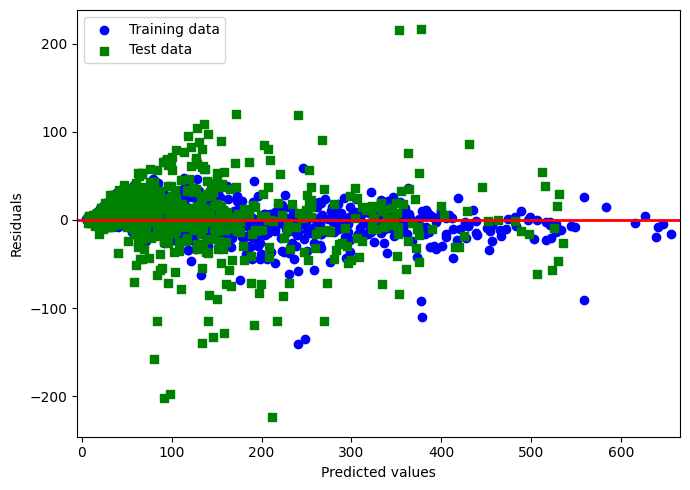

In [7]:
# Random Forest Regression

forest = RandomForestRegressor(
    n_estimators=1000,
    criterion='squared_error',
    random_state=1,
    n_jobs=-1
)

forest.fit(X_train, y_train)

y_train_pred_f = forest.predict(X_train)
y_test_pred_f = forest.predict(X_test)

print('[Random Forest Regression]')
print('MSE  train: %.2f, test: %.2f' % (
    mean_squared_error(y_train, y_train_pred_f),
    mean_squared_error(y_test, y_test_pred_f)
))
print('R^2  train: %.2f, test: %.2f' % (
    r2_score(y_train, y_train_pred_f),
    r2_score(y_test, y_test_pred_f)
))

# 殘差圖
plt.figure(figsize=(7, 5))

plt.scatter(
    y_train_pred_f,
    y_train_pred_f - y_train,
    c='blue',
    marker='o',
    label='Training data'
)
plt.scatter(
    y_test_pred_f,
    y_test_pred_f - y_test,
    c='green',
    marker='s',
    label='Test data'
)

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')

xmin = min(y_train_pred_f.min(), y_test_pred_f.min()) - 10
xmax = max(y_train_pred_f.max(), y_test_pred_f.max()) + 10
plt.hlines(y=0, xmin=xmin, xmax=xmax, lw=2, color='red')
plt.xlim([xmin, xmax])

plt.tight_layout()
plt.show()
